In [4]:
from data import load_data, data_prep
from train import train, objective, build_hidden_mults
from data_openml import DataSetCatCon
from torch.utils.data import DataLoader
from models import SAINT
import torch.optim as optim
from sklearn.feature_selection import SelectFromModel
from catboost import CatBoostRegressor
import pandas as pd
import optuna
import numpy as np
import torch

##################################
MAX_FEATURES=100
N_TRIALS=2
N_ROWS = None    # Set to None to use all rows
##################################

X, y = load_data(n_rows=N_ROWS)

#========> Set a random seed for reproducibility
np.random.seed(239048)
cat_dims, cat_idxs, con_idxs, X_train, y_train, X_valid, y_valid, X_test, y_test, train_mean, train_std, continuous_mean_std = data_prep(X, y, datasplit=[.65, .15, .2])


In [5]:
# select best fingerprints 
X_catboost = pd.DataFrame(X_train["data"])
categorical_columns = [X_catboost.columns[i] for i in cat_idxs]
for col in categorical_columns:
    X_catboost[col] = X_catboost[col].astype("int")
model2 = CatBoostRegressor(cat_features=cat_idxs)  # FIXME
#================> should use only train data to avoid data leakage
model2.fit(X_catboost, y_train["data"])
#==================> To only select based on max_features, set threshold=-np.inf.
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html
fgpts_selector = SelectFromModel(model2, prefit=True, threshold=-np.inf, max_features=MAX_FEATURES)


Learning rate set to 0.038268
0:	learn: 11.9915239	total: 45.7ms	remaining: 45.7s
1:	learn: 11.7819741	total: 83ms	remaining: 41.4s
2:	learn: 11.5472745	total: 121ms	remaining: 40.2s
3:	learn: 11.3434493	total: 159ms	remaining: 39.7s
4:	learn: 11.1723092	total: 197ms	remaining: 39.2s
5:	learn: 10.9836465	total: 244ms	remaining: 40.4s
6:	learn: 10.8135996	total: 280ms	remaining: 39.7s
7:	learn: 10.6025000	total: 319ms	remaining: 39.5s
8:	learn: 10.4289512	total: 358ms	remaining: 39.4s
9:	learn: 10.2899409	total: 397ms	remaining: 39.3s
10:	learn: 10.1564057	total: 442ms	remaining: 39.7s
11:	learn: 10.0014319	total: 489ms	remaining: 40.2s
12:	learn: 9.8178619	total: 524ms	remaining: 39.8s
13:	learn: 9.6947081	total: 560ms	remaining: 39.4s
14:	learn: 9.5612110	total: 600ms	remaining: 39.4s
15:	learn: 9.4106335	total: 635ms	remaining: 39.1s
16:	learn: 9.2894530	total: 678ms	remaining: 39.2s
17:	learn: 9.1511145	total: 715ms	remaining: 39s
18:	learn: 9.0188623	total: 752ms	remaining: 38.8s
1

In [8]:
features_mask = fgpts_selector.get_support()
# Force that both m/z and adduct are always selected 
features_mask[0] = True
features_mask[1] = True
# Ensure m/z is always selected
assert features_mask[0] == True
# Ensure adduct is always selected
assert features_mask[1] == True

n_features = X_train["data"][:, features_mask].shape[1]

cat_idxs = list(range(1, n_features))
print(cat_idxs)
cat_dims = cat_dims[:n_features]
print(cat_dims)

X_train["data"] = X_train["data"][:, features_mask]
X_train["mask"] = X_train["mask"][:, features_mask]
X_valid["data"] = X_valid["data"][:, features_mask]
X_valid["mask"] = X_valid["mask"][:, features_mask]
X_test["data"] = X_test["data"][:, features_mask]
X_test["mask"] = X_test["mask"][:, features_mask]



[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
[1 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [9]:
train_ds = DataSetCatCon(X_train, y_train, cat_idxs,'reg',continuous_mean_std)
trainloader = DataLoader(train_ds, batch_size=256, shuffle=True,num_workers=4)

valid_ds = DataSetCatCon(X_valid, y_valid, cat_idxs,'reg', continuous_mean_std)
validloader = DataLoader(valid_ds, batch_size=256, shuffle=False,num_workers=4)

test_ds = DataSetCatCon(X_test, y_test, cat_idxs,'reg', continuous_mean_std)
testloader = DataLoader(test_ds, batch_size=256, shuffle=False,num_workers=4)

In [11]:
# select best hyperparameters

storage_name = "sqlite:///saint.db"
study1 = optuna.create_study(study_name="step-1", storage=storage_name, load_if_exists=True)

study1.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, testloader, first_trial=True), n_trials=N_TRIALS)
optim_params1 = study1.best_params 

lr = optim_params1['lr']
wd = optim_params1['weight_decay']

[I 2024-06-19 21:56:28,429] A new study created in RDB with name: step-1
[I 2024-06-19 21:56:44,653] Trial 0 finished with value: 54.68489166895549 and parameters: {'lr': 0.000635917559773718, 'weight_decay': 0.06722084118796293}. Best is trial 0 with value: 54.68489166895549.
[I 2024-06-19 21:56:59,910] Trial 1 finished with value: 57.409529050191246 and parameters: {'lr': 0.0002402685876849398, 'weight_decay': 0.09425609659207738}. Best is trial 0 with value: 54.68489166895549.


5277798092670035541


In [17]:
# Create an unique id for step-2 based on the best hyperparameters from step-1
unique_id = hash("{}-{}".format(str(lr), str(wd)))
study = optuna.create_study(
    study_name=f"id_{unique_id}_step-2",
    storage=storage_name,
    direction="minimize",
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, max_resource=10, reduction_factor=3
    ),
    load_if_exists=True
)
study.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, testloader, lr=lr, wd=wd), n_trials=N_TRIALS)
optim_params = study.best_params 

[I 2024-06-19 21:59:42,792] A new study created in RDB with name: id_5277798092670035541_step-2
[W 2024-06-19 21:59:51,822] Trial 0 failed with parameters: {'dim': 51, 'depth': 3, 'heads': 5, 'attn_dropout': 0.32704481266741237, 'ff_dropout': 0.38657257164437764, 'mlp_hidden_mults': 8, 'final_mlp_style': 'sep', 'optimizer': 'SGD', 'scheduler': 'cosine'} because of the following error: OutOfMemoryError('CUDA out of memory. Tried to allocate 826.00 MiB. GPU 0 has a total capacity of 5.92 GiB of which 232.75 MiB is free. Including non-PyTorch memory, this process has 5.69 GiB memory in use. Of the allocated memory 5.50 GiB is allocated by PyTorch, and 100.89 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)').
Traceback (most recent call last):
  File "/ho

OutOfMemoryError: CUDA out of memory. Tried to allocate 826.00 MiB. GPU 0 has a total capacity of 5.92 GiB of which 232.75 MiB is free. Including non-PyTorch memory, this process has 5.69 GiB memory in use. Of the allocated memory 5.50 GiB is allocated by PyTorch, and 100.89 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

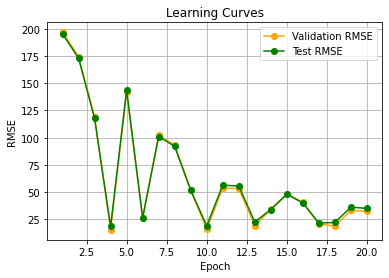

In [3]:
optim_params['mlp_hidden_mults'] = build_hidden_mults(optim_params['mlp_hidden_mults'])  # TODO: importar funcion

model = SAINT(
    categories = tuple(cat_dims), 
    num_continuous = len(con_idxs),                
    dim = optim_params['dim'],                         
    dim_out = 1,                       
    depth = optim_params['depth'],                        
    heads = optim_params['heads'],                         
    attn_dropout = optim_params['attn_dropout'],             
    ff_dropout = optim_params['ff_dropout'],                  
    mlp_hidden_mults = optim_params['mlp_hidden_mults'],       
    cont_embeddings = 'MLP',
    attentiontype = 'colrow',
    final_mlp_style = optim_params['final_mlp_style'],
    y_dim = 1 # porque es regression 
)

epochs = 10

if optim_params['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=optim_params1['lr'], momentum=0.9, weight_decay=optim_params1['weight_decay'])
elif optim_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(model.parameters(),lr=optim_params1['lr'])
elif optim_params['optimizer'] == 'AdamW':
    optimizer = optim.AdamW(model.parameters(),lr=optim_params1['lr'])

if optim_params['scheduler'] == 'cosine':
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
elif optim_params['scheduler'] == 'linear':
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[epochs // 2.667, epochs // 1.6, epochs // 1.142], gamma=0.1)

valid_rmse = train(model, optimizer, scheduler, epochs, trainloader, validloader, testloader, plot=True)


- load_data de toda la db
- epochs (en objective y main)
- n_trials en study.optimize